<iframe src="overview.html" width="100%" height="600"></iframe>

### 🧭 Cell 1 — 数据加载与实验总体框架说明

本 Notebook 旨在通过 **uplift 建模（异质性因果效应分析）** 方法，探究酒店押金策略（`deposit_type`）对客户取消行为（`is_canceled`）的真实影响。
研究目标是回答以下核心问题：

> 💡 “押金是否真的能降低取消率？
> 或者，不同客户群体对押金的敏感程度是否存在显著差异？”

#### 📘 分析思路总览

1. **数据加载与清洗**：读取并初步审查 `hotel_bookings.csv` 数据集结构（共 32 列、约 12 万条样本）。
2. **实验构造**：

   * 定义「押金 vs 无押金」为 treatment 变量；
   * 定义取消（`is_canceled=1`）为目标行为。
3. **样本平衡**：

   * 通过 **倾向得分 (Propensity Score)** 与 **逆概率加权 (IPW)** 消除自选择偏差；
   * 确保两组客户在基础特征上可比。
4. **双模型训练（T-Learner）**：

   * 训练两套加权模型 `f1`（有押金）与 `f0`（无押金）；
   * 分别预测每个客户在两种情景下的取消概率。
5. **uplift 估计与策略洞察**：

   * uplift = `f1(X)` − `f0(X)` 表示押金的边际影响；
   * 分析 uplift 分布，识别「押金敏感型客户」与「押金无感型客户」；
   * 基于结果制定押金差异化策略与心理行为解释。

#### 🧩 数据集简介

* **文件路径**：`./archive_8/hotel_bookings.csv`
* **样本规模**：119,390 条预订记录
* **主要字段**：

  * `deposit_type`：押金类型（No Deposit / Non Refund / Refundable）
  * `is_canceled`：是否取消（0/1）
  * `lead_time`：提前预订天数
  * `customer_type`、`market_segment`、`special_requests` 等用于控制样本异质性

通过本 Notebook，我们将展示一个从 **A/B 因果推断 → uplift 建模 → 反直觉策略结论** 的完整流程。


In [1]:
# # 📊 Overview Visualization — Project Pipeline
# from IPython.display import IFrame
#
# IFrame("overview.html", width="100%", height=600)


In [2]:
# Cell 1 — 基础环境与数据加载
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pylab import mpl, plt
import json
import os

# best font and style settings for notebook 
warnings.filterwarnings('ignore')
mpl.rcParams['font.family'] = 'MiSans'  # 若报字体找不到，可注释掉

# 路径：按你本地为准
DATA_PATH = "./archive_8/hotel_bookings.csv"
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:], "...")  # 先看一部分
df.head(10)

Shape: (119390, 32)
Columns: ['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date'] ...


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


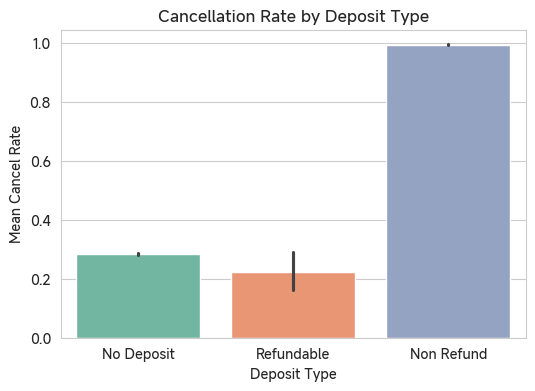

In [3]:
plt.figure(figsize=(6, 4))
sns.barplot(x='deposit_type', y='is_canceled', data=df, estimator=np.mean, palette='Set2')
plt.title("Cancellation Rate by Deposit Type")
plt.ylabel("Mean Cancel Rate")
plt.xlabel("Deposit Type")
plt.show()


In [4]:
# Cell 1 — 构造 A/B 实验变量
df_ab = df.copy()

# 举例：以押金策略为“实验”
df_ab["treatment"] = (df_ab["deposit_type"] != "No Deposit").astype(int)

# Target: 取消=1
df_ab["target"] = df_ab["is_canceled"].astype(int)

print(df_ab[["deposit_type", "treatment", "target"]].head())
print(df_ab["treatment"].value_counts(normalize=True))


  deposit_type  treatment  target
0   No Deposit          0       0
1   No Deposit          0       0
2   No Deposit          0       0
3   No Deposit          0       0
4   No Deposit          0       0
treatment
0    0.876464
1    0.123536
Name: proportion, dtype: float64


In [5]:
# Cell 2 — 基本AB检验
control = df_ab.loc[df_ab.treatment == 0, "target"]
treat = df_ab.loc[df_ab.treatment == 1, "target"]

uplift_mean = treat.mean() - control.mean()
print(f"Baseline Cancel Rate (Control): {control.mean():.4f}")
print(f"Cancel Rate (Treatment): {treat.mean():.4f}")
print(f"ATE (Raw uplift): {uplift_mean:.4f}")


Baseline Cancel Rate (Control): 0.2838
Cancel Rate (Treatment): 0.9852
ATE (Raw uplift): 0.7014


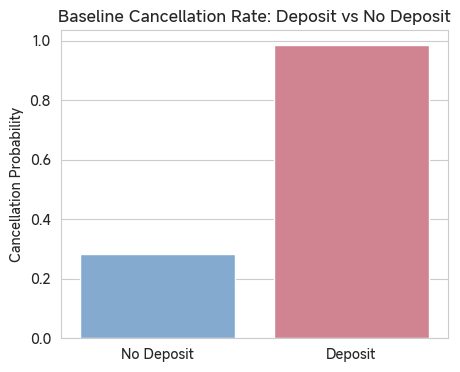

In [6]:
plt.figure(figsize=(5, 4))
sns.barplot(x=["No Deposit", "Deposit"],
            y=[control.mean(), treat.mean()],
            palette=["#77aadd", "#dd7788"],
            ci=95)
plt.title("Baseline Cancellation Rate: Deposit vs No Deposit")
plt.ylabel("Cancellation Probability")
plt.show()


In [7]:
# Cell 3 — 特征准备
cols = ["hotel", "market_segment", "lead_time", "previous_cancellations", "booking_changes",
        "total_of_special_requests", "days_in_waiting_list"]
X = pd.get_dummies(df_ab[cols], drop_first=True)
y = df_ab["target"]
t = df_ab["treatment"]


## 真正执行 Propensity Matching

In [8]:
# from sklearn.neighbors import NearestNeighbors
#
# treated_idx = df_ab[df_ab.treatment == 1].index
# control_idx = df_ab[df_ab.treatment == 0].index
#
# # 基于倾向得分做最近邻匹配
# nbrs = NearestNeighbors(n_neighbors=1).fit(ps[control_idx].values.reshape(-1,1))
# distances, indices = nbrs.kneighbors(ps[treated_idx].values.reshape(-1,1))
# matched_control_idx = control_idx[indices.flatten()]
#
# matched_idx = np.concatenate([treated_idx, matched_control_idx])
# df_matched = df_ab.loc[matched_idx]
#
# # 用匹配后样本训练 f1, f0
# f1.fit(X.loc[treated_idx], y.loc[treated_idx])
# f0.fit(X.loc[matched_control_idx], y.loc[matched_control_idx])


## 不平衡样本

In [9]:
# # Cell 4 — 训练两套模型
# from sklearn.ensemble import GradientBoostingClassifier
# 
# f1 = GradientBoostingClassifier(random_state=42)
# f0 = GradientBoostingClassifier(random_state=42)
# 
# f1.fit(X[t == 1], y[t == 1])
# f0.fit(X[t == 0], y[t == 0])


## 使用 Inverse Probability Weighting (IPW)

```mermaid
flowchart LR

    A[Raw dataset df_ab<br>Features describing customers and bookings<br>Variable t indicates deposit required or not<br>Variable y indicates cancellation]
        --> B[Estimate propensity score using logistic regression or CatBoost]

    B --> C[Propensity score represents likelihood of receiving deposit condition]

    C --> D[Clip propensity values to range 0.01 to 0.99 in order to avoid extreme weights]

    D --> E[Compute inverse probability weights<br>w_treat computed as one divided by propensity<br>w_ctrl computed as one divided by one minus propensity]

    E --> F[Normalize weights so that total sample weight remains stable]

    F --> G1[Train model f1 on cases where deposit was required<br>Model outputs predicted cancellation under deposit]

    F --> G0[Train model f0 on cases where no deposit was required<br>Model outputs predicted cancellation under no deposit]

    G1 --> H1[p1 represents predicted cancellation probability under deposit]
    G0 --> H0[p0 represents predicted cancellation probability under no deposit]

    H1 --> I[Compute uplift value as difference p1 minus p0]
    H0 --> I

    I --> J[Group users into uplift deciles indicating sensitivity to deposit]

    J --> K[Policy decisions<br>High uplift group: waive deposit<br>Low uplift group: require deposit]

```


In [10]:
# Cell 3.5 — Propensity Score Estimation
from sklearn.linear_model import LogisticRegression

ps_model = LogisticRegression(max_iter=200)
ps_model.fit(X, t)
df_ab["propensity"] = ps_model.predict_proba(X)[:, 1]

# Cell 3.6 — Inverse Probability Weighting (IPW)
ps = df_ab["propensity"].clip(0.01, 0.99)
w_treat = 1 / ps
w_ctrl = 1 / (1 - ps)

# 标准化权重（推荐）
w_treat /= np.mean(w_treat[t == 1])
w_ctrl /= np.mean(w_ctrl[t == 0])


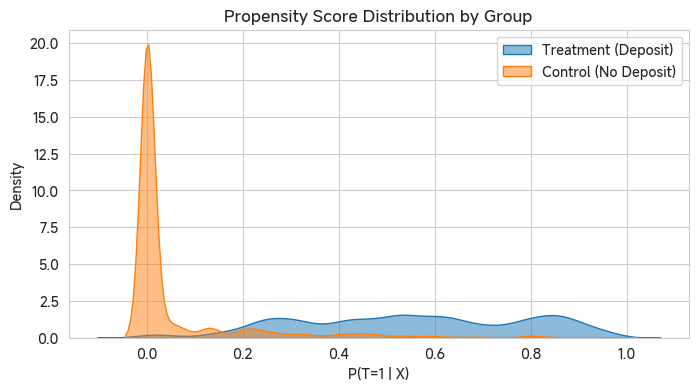

In [11]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_ab.loc[t == 1, "propensity"], label="Treatment (Deposit)", fill=True, alpha=0.5)
sns.kdeplot(df_ab.loc[t == 0, "propensity"], label="Control (No Deposit)", fill=True, alpha=0.5)
plt.title("Propensity Score Distribution by Group")
plt.xlabel("P(T=1 | X)")
plt.ylabel("Density")
plt.legend()
plt.show()


### 🧩 Cell 4 — Weighted Model Training（加权双模型训练说明）

在这一单元中，我们训练两套独立的模型 `f1` 与 `f0`，分别用于估计个体在**有押金（treatment=1）**与**无押金（treatment=0）**情况下的取消概率。
#### 🎯 目的

* 建立**个体化反事实预测（individual counterfactual prediction）**；
* 用来计算每个客户的 uplift：
  $$
  \text{uplift} = P(\text{cancel} | \text{押金}) - P(\text{cancel} | \text{无押金})
  $$
#### ⚖️ 方法与加权逻辑

1. **f₁ 模型（treatment group）**

   * 在押金客户子集上训练；
   * 使用 `w_treat` 作为样本权重。
   * 权重来源于倾向得分逆概率加权 (IPW)，确保样本在特征空间上与对照组分布一致。
2. **f₀ 模型（control group）**

   * 在无押金客户子集上训练；
   * 使用 `w_ctrl` 作为样本权重。
   * 同样通过 IPW 调整，使模型学习到“如果这些样本在 treatment 状态下会如何表现”。
#### 🔍 模型配置
使用 **Gradient Boosting Classifier**（梯度提升分类器）：
* `n_estimators=200` → 控制弱学习器数量，保证模型复杂度；
* `learning_rate=0.05` → 防止过拟合；
* `max_depth=4` → 限制单棵树的深度；
* `random_state=42` → 保证可复现性。


In [12]:
# Cell 4 — Weighted Model Training
from sklearn.ensemble import GradientBoostingClassifier

f1 = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05,
                                max_depth=6, random_state=42)
f0 = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05,
                                max_depth=6, random_state=42)

# Weighted fitting
# f1.fit(X[t == 1], y[t == 1])
# f0.fit(X[t == 0], y[t == 0])
f1.fit(X[t == 1], y[t == 1], sample_weight=w_treat[t == 1])
f0.fit(X[t == 0], y[t == 0], sample_weight=w_ctrl[t == 0])

GradientBoostingClassifier(learning_rate=0.05, max_depth=6, n_estimators=300,
                           random_state=42)

In [13]:
from sklearn.metrics import accuracy_score

# treatment=1 人群：用 f1 预测
y_pred_t1 = (f1.predict_proba(X[t == 1])[:, 1] > 0.5).astype(int)
acc_t1 = accuracy_score(y[t == 1], y_pred_t1)

# treatment=0 人群：用 f0 预测
y_pred_t0 = (f0.predict_proba(X[t == 0])[:, 1] > 0.5).astype(int)
acc_t0 = accuracy_score(y[t == 0], y_pred_t0)

print("Accuracy (treatment=1, 收押金人群):", round(acc_t1, 4))
print("Accuracy (treatment=0, 无押金人群):", round(acc_t0, 4))


Accuracy (treatment=1, 收押金人群): 0.9988
Accuracy (treatment=0, 无押金人群): 0.7923


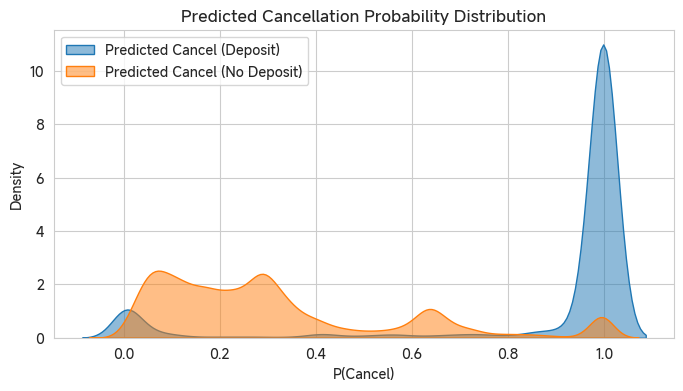

In [14]:
p1 = f1.predict_proba(X)[:, 1]
p0 = f0.predict_proba(X)[:, 1]

plt.figure(figsize=(8, 4))
sns.kdeplot(p1, label="Predicted Cancel (Deposit)", fill=True, alpha=0.5)
sns.kdeplot(p0, label="Predicted Cancel (No Deposit)", fill=True, alpha=0.5)
plt.title("Predicted Cancellation Probability Distribution")
plt.xlabel("P(Cancel)")
plt.legend()
plt.show()


In [15]:
# plt.figure(figsize=(7, 4))
# sns.swarmplot(data=df_plot, x="group", y="prob", size=2, alpha=0.6)
# plt.title("Bee Swarm Distribution View")
# plt.show()

<Figure size 640x480 with 0 Axes>

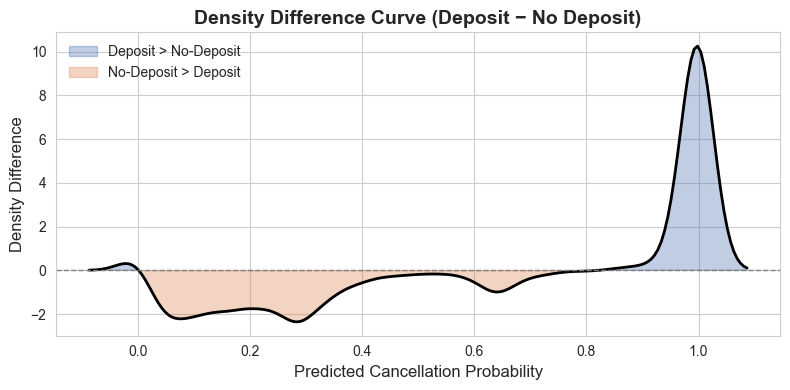

In [16]:
# KDE 数据
kde1 = sns.kdeplot(p1, bw_adjust=1, color="#4C72B0").get_lines()[0].get_data()
kde2 = sns.kdeplot(p0, bw_adjust=1, color="#DD8452").get_lines()[1].get_data()
plt.clf()  # 清掉刚才临时图形

x = kde1[0]
diff = kde1[1] - kde2[1]

plt.figure(figsize=(8, 4))
sns.set_style("whitegrid")

# 填充 >0（Deposit 组密度更高）
plt.fill_between(x, diff, 0, where=diff > 0, interpolate=True,
                 color="#4C72B0", alpha=0.35, label="Deposit > No-Deposit")

# 填充 <0（No-Deposit 组密度更高）
plt.fill_between(x, diff, 0, where=diff < 0, interpolate=True,
                 color="#DD8452", alpha=0.35, label="No-Deposit > Deposit")

# 主差异线
plt.plot(x, diff, color="black", linewidth=2)

# 零基线
plt.axhline(0, linestyle='--', color="gray", linewidth=1)

plt.title("Density Difference Curve (Deposit − No Deposit)", fontsize=14, weight="bold")
plt.xlabel("Predicted Cancellation Probability", fontsize=12)
plt.ylabel("Density Difference", fontsize=12)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [17]:
# Cell 4.1 — 模型正确率评估
from sklearn.metrics import accuracy_score

# 各自分组上的预测
pred1 = f1.predict(X[t == 1])
pred0 = f0.predict(X[t == 0])

acc1 = accuracy_score(y[t == 1], pred1)
acc0 = accuracy_score(y[t == 0], pred0)

print(f"🎯 f1（有押金组）模型训练准确率：{acc1:.4f}")
print(f"🎯 f0（无押金组）模型训练准确率：{acc0:.4f}")
print(f"平均模型准确率：{(acc1 + acc0) / 2:.4f}")


🎯 f1（有押金组）模型训练准确率：0.9988
🎯 f0（无押金组）模型训练准确率：0.7923
平均模型准确率：0.8955


In [18]:
# Cell 5 — 个体 uplift
p1 = f1.predict_proba(X)[:, 1]
p0 = f0.predict_proba(X)[:, 1]
uplift = p1 - p0

df_ab["uplift"] = uplift
df_ab[["uplift"]].describe()

,uplift
count,119390.000000
mean,0.564235
std,0.333543
min,-0.973443
25%,0.363145
50%,0.688220
75%,0.819945
max,0.999563


In [19]:
sum(df_ab['uplift'] > 0), len(df_ab)

(108093, 119390)

<Axes: xlabel='adr', ylabel='Density'>

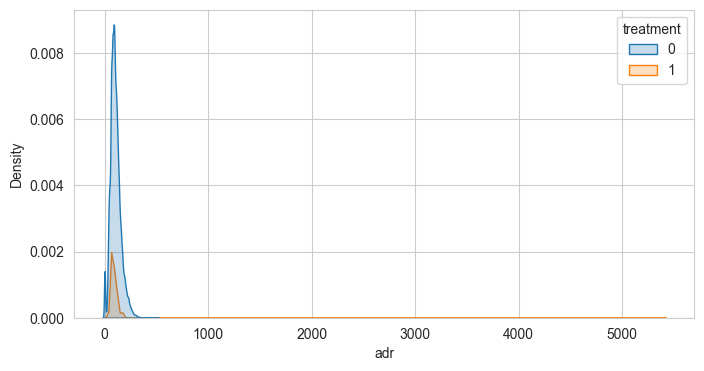

In [20]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data=df_ab, x="adr", hue="treatment", fill=True)

<Axes: xlabel='customer_type', ylabel='count'>

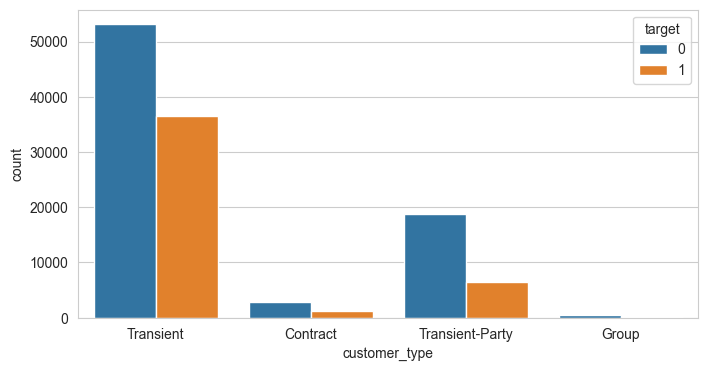

In [21]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_ab, x="customer_type", hue="target")

| 变量                       | 现象             | 解释含义                  |
| ------------------------ | -------------- | --------------------- |
| **adr**                  | 分布极度右偏（少数超高价格） | 酒店有少量高价房，但大多数订单价格低    |
| **lead_time**            | 部分预订提前很久       | 越早预订 → 可能更容易取消（“备胎单”） |
| **stays_in_week_nights** | 住 1–5 晚居多      | 常规旅游/商务行为             |
| **uplift**               | 分布多峰           | 人群分层明显 → 押金对不同人群影响不同  |


In [22]:
# sns.pairplot(df_ab[['adr', 'lead_time', 'stays_in_week_nights', 'uplift', 'target']], hue="target")

## 💡 押金高敏感客户，反而本身的取消率低。

### 🎯 策略：对于押金高敏感用户，在他们完成预订后——

* **不应再推送更优惠或替代性产品**。
  这类用户在心理上对押金高度敏感、风险厌恶，
  一旦预订后又接收到新的“更划算选择”，会产生**认知失调与选择后悔**，
  从而陷入反复比较 → 修改 → 取消的循环。

* **建议采取“静默成交”策略**：
  在他们完成下单后，不再触发追加优惠或交叉推荐，
  让其保持决策的封闭性与心理确定性，降低取消率。

* **押金政策可适度宽松或豁免**：
  因为模型显示他们即便不被强制约束，也极少取消。
  相反，免押金反而提升他们的信任度与满意度。
  对于高价值会员或提前规划型客户，可尝试「免押金—忠诚返还」等机制。


### 💼 对比策略：针对押金低敏感用户

* **这类人群“押金无感”，却更容易临时变动**。
  他们的高取消率不是因为押金存在，而是因为**预订动机弱、计划随意**。
  因此，应：

  * 收取全额押金或不可退预订；
  * 或采用「押金抵用消费」「押金锁定优惠」的金融型激励；
  * 明确取消成本，引导他们做出稳定承诺。



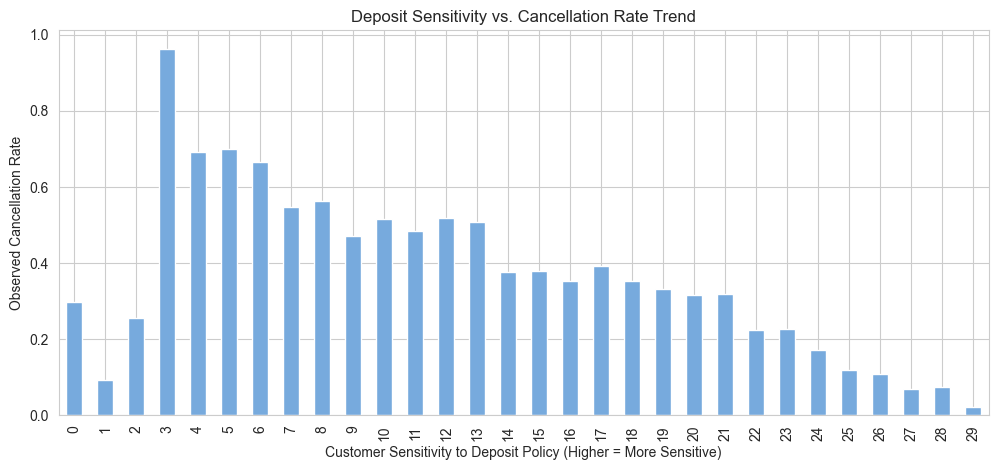

In [23]:
# # Cell 6 — uplift 排序分组
# df_ab["uplift_decile"] = pd.qcut(df_ab["uplift"], 20, labels=False)
# uplift_summary = df_ab.groupby("uplift_decile")["target"].mean()
# 
# plt.figure(figsize=(12, 5))
# uplift_summary.plot(kind="bar", color="#77aadd")
# plt.title("押金敏感度与取消率趋势图")
# plt.xlabel("对于是否有押金的敏感程度")
# plt.ylabel("取消率")
# plt.show()
# Cell 6 — Uplift Decile Grouping and Visualization
class_num = 30
df_ab["uplift_decile"] = pd.qcut(df_ab["uplift"], class_num, labels=False)
uplift_summary = df_ab.groupby("uplift_decile")["target"].mean()

plt.figure(figsize=(12, 5))
uplift_summary.plot(kind="bar", color="#77aadd")
plt.title("Deposit Sensitivity vs. Cancellation Rate Trend")
plt.xlabel("Customer Sensitivity to Deposit Policy (Higher = More Sensitive)")
plt.ylabel("Observed Cancellation Rate")
plt.show()


In [24]:
# df_ab[['uplift', "uplift_decile"]]

In [25]:
plot_df = uplift_summary.reset_index()
plot_df.columns = ["uplift_decile", "cancel_rate"]

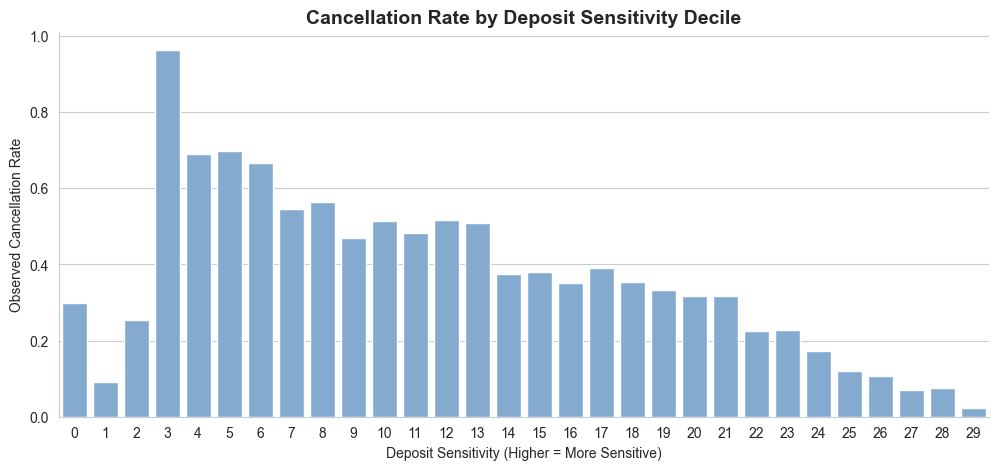

In [26]:
plt.figure(figsize=(12, 5))
sns.barplot(data=plot_df, x="uplift_decile", y="cancel_rate", color="#77aadd")
plt.title("Cancellation Rate by Deposit Sensitivity Decile", fontsize=14, weight="bold")
plt.xlabel("Deposit Sensitivity (Higher = More Sensitive)")
plt.ylabel("Observed Cancellation Rate")
sns.despine()
plt.show()


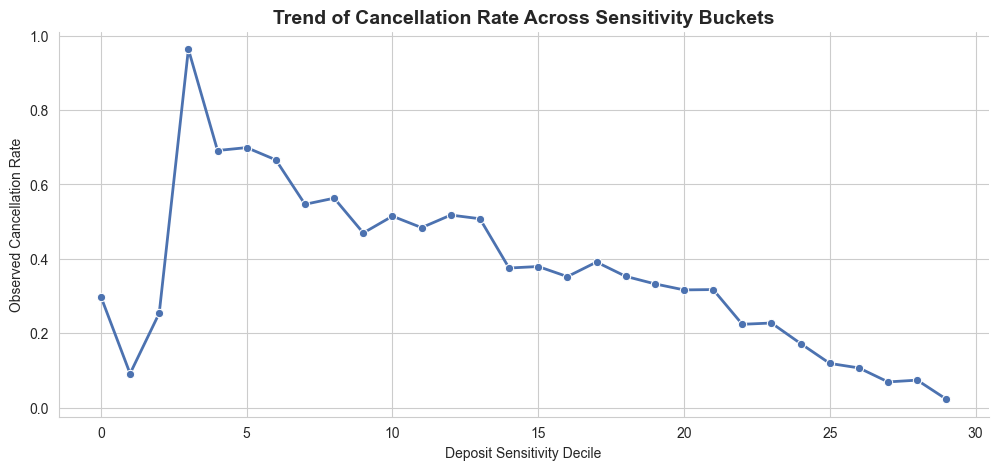

In [27]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=plot_df, x="uplift_decile", y="cancel_rate", marker="o", linewidth=2, color="#4C72B0")
plt.title("Trend of Cancellation Rate Across Sensitivity Buckets", fontsize=14, weight="bold")
plt.xlabel("Deposit Sensitivity Decile")
plt.ylabel("Observed Cancellation Rate")
sns.despine()
plt.show()


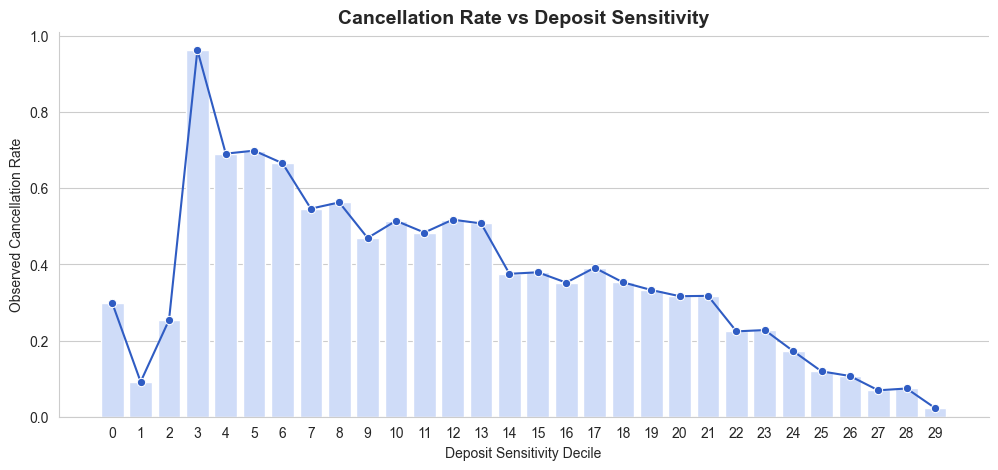

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.barplot(data=plot_df, x="uplift_decile", y="cancel_rate", color="#c8d9ff", ax=ax)
sns.lineplot(data=plot_df, x="uplift_decile", y="cancel_rate", marker="o", color="#2f5cc3", ax=ax)

ax.set_title("Cancellation Rate vs Deposit Sensitivity", fontsize=14, weight="bold")
ax.set_xlabel("Deposit Sensitivity Decile")
ax.set_ylabel("Observed Cancellation Rate")
sns.despine()
plt.show()


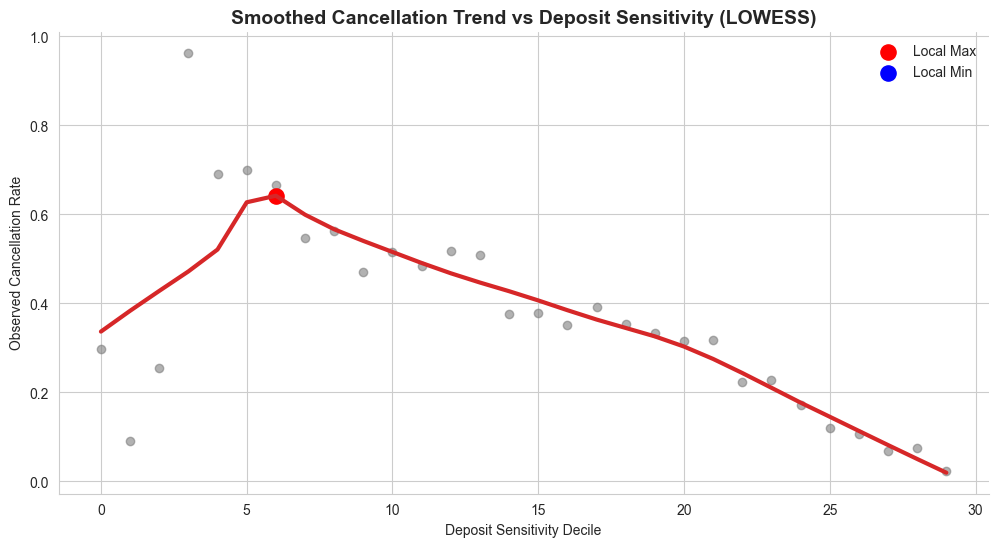

Local max points: [(6.0, 0.6420749618017977)]
Local min points: []


In [29]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# LOWESS 平滑
lowess_curve = lowess(plot_df["cancel_rate"], plot_df["uplift_decile"], frac=0.4)
x_smooth = lowess_curve[:, 0]
y_smooth = lowess_curve[:, 1]

# 找极值点（简单一阶差分符号变化法）
dy = np.diff(y_smooth)

# 极大值：由上升转下降 → dy 前正后负
max_points = np.where((np.hstack([dy, 0]) < 0) & (np.hstack([0, dy]) > 0))[0]

# 极小值：由下降转上升 → dy 前负后正
min_points = np.where((np.hstack([dy, 0]) > 0) & (np.hstack([0, dy]) < 0))[0]

# 绘图
plt.figure(figsize=(12, 6))
plt.scatter(plot_df["uplift_decile"], plot_df["cancel_rate"], color="#7f7f7f", alpha=0.6)
plt.plot(x_smooth, y_smooth, color="#d62728", linewidth=3)

# 标记极大值（红色）
plt.scatter(x_smooth[max_points], y_smooth[max_points], color="red", s=120, label="Local Max")

# 标记极小值（蓝色）
plt.scatter(x_smooth[min_points], y_smooth[min_points], color="blue", s=120, label="Local Min")

plt.title("Smoothed Cancellation Trend vs Deposit Sensitivity (LOWESS)", fontsize=14, weight="bold")
plt.xlabel("Deposit Sensitivity Decile")
plt.ylabel("Observed Cancellation Rate")
plt.legend(frameon=False)
sns.despine()
plt.show()

print("Local max points:", list(zip(x_smooth[max_points], y_smooth[max_points])))
print("Local min points:", list(zip(x_smooth[min_points], y_smooth[min_points])))


In [30]:
lowess_curve[:, 0], lowess_curve[:, 1]

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29.]),
 array([0.33676902, 0.383498  , 0.42818498, 0.47200341, 0.52121411,
        0.62733587, 0.64207496, 0.59955019, 0.56670846, 0.54054394,
        0.51572669, 0.49098068, 0.4678407 , 0.4470123 , 0.42755221,
        0.40681609, 0.38487306, 0.36387504, 0.34498133, 0.32604801,
        0.30318355, 0.27530226, 0.24369037, 0.21049553, 0.17714517,
        0.14541047, 0.11351441, 0.08178171, 0.05044357, 0.01963138]))

In [31]:
print(uplift_summary)

uplift_decile
0     0.298504
1     0.091707
2     0.254157
3     0.963460
4     0.691270
5     0.699100
6     0.666080
7     0.546720
8     0.563175
9     0.469693
10    0.514839
11    0.483993
12    0.517794
13    0.507882
14    0.375481
15    0.379523
16    0.352393
17    0.391472
18    0.353119
19    0.332914
20    0.316675
21    0.317576
22    0.224259
23    0.227693
24    0.172518
25    0.119185
26    0.107008
27    0.069391
28    0.074190
29    0.022899
Name: target, dtype: float64


## 结论验证
一共分为20组，15~20作为高uplift组，0-5作为低uplift组

In [32]:
# =============================
# 验证 uplift 的因果含义（押金敏感性与取消行为）
# =============================

# baseline_p0 = 模型预测：在「不收押金」的情况下取消的概率
df_ab["baseline_p0"] = f0.predict_proba(X)[:, 1]

# baseline_p1 = 模型预测：在「收押金」的情况下取消的概率
df_ab["baseline_p1"] = f1.predict_proba(X)[:, 1]

# 选择 top 25% uplift 为 “高敏感用户” ，bottom 25% uplift 为 “低敏感用户”
ratio = 0.2
high_uplift = df_ab[df_ab["uplift_decile"] >= int(class_num ** (1 - ratio))]
low_uplift = df_ab[
    (df_ab["uplift_decile"] <= int(class_num ** ratio))
    &
    (df_ab["uplift_decile"] >= 0)]

# ---- 对比两类人群在“理论不收押金条件下”的基础取消风险 ----
print("High-uplift baseline cancel prob (no deposit):", high_uplift["baseline_p0"].mean())
print("Low-uplift baseline cancel prob (no  deposit):", low_uplift["baseline_p0"].mean())

# ---- 对比两类人群在“理论收押金条件下”的取消风险 ----
print("High-uplift baseline cancel prob (with deposit):", high_uplift["baseline_p1"].mean())
print("Low-uplift baseline cancel prob (with  deposit):", low_uplift["baseline_p1"].mean())

# =============================
# 真实世界中（观察数据中）收不收押金后的实际取消率
# =============================

# 高 uplift：押金敏感/反感群体
high_uplift_t1 = high_uplift[high_uplift["treatment"] == 1]["target"].mean()  # 收押金时实际取消率
high_uplift_t0 = high_uplift[high_uplift["treatment"] == 0]["target"].mean()  # 不收押金时实际取消率

# 低 uplift：押金约束有效群体
low_uplift_t1 = low_uplift[low_uplift["treatment"] == 1]["target"].mean()  # 收押金时实际取消率
low_uplift_t0 = low_uplift[low_uplift["treatment"] == 0]["target"].mean()  # 不收押金时实际取消率

print("High-uplift (收押金) 实际取消率:", high_uplift_t1)
print("High-uplift (不收押金) 实际取消率:", high_uplift_t0)
print("Low-uplift  (收押金) 实际取消率:", low_uplift_t1)
print("Low-uplift  (不收押金) 实际取消率:", low_uplift_t0)

import pandas as pd

# ===== 1) 模型反事实预测矩阵 (Predicted Counterfactual Effects) =====
pred_matrix = pd.DataFrame({
    "No Deposit (Predicted)": [
        high_uplift["baseline_p0"].mean(),
        low_uplift["baseline_p0"].mean()
    ],
    "Deposit (Predicted)": [
        high_uplift["baseline_p1"].mean(),
        low_uplift["baseline_p1"].mean()
    ]
}, index=["High-Uplift Users", "Low-Uplift Users"])

print("📌 Predicted Cancellation Probability (Counterfactual Model)")
display(pred_matrix.style.background_gradient(cmap="Blues").format("{:.3f}"))

# ===== 2) 真实观测行为矩阵 (Empirical / Observed Effects) =====
actual_matrix = pd.DataFrame({
    "No Deposit (Observed)": [
        high_uplift_t0,
        low_uplift_t0
    ],
    "Deposit (Observed)": [
        high_uplift_t1,
        low_uplift_t1
    ]
}, index=["High-Uplift Users", "Low-Uplift Users"])

print("📌 Observed Cancellation Rate (Real Behavior)")
display(actual_matrix.style.background_gradient(cmap="Reds").format("{:.3f}"))


High-uplift baseline cancel prob (no deposit): 0.17091032057473826
Low-uplift baseline cancel prob (no  deposit): 0.19806266320916463
High-uplift baseline cancel prob (with deposit): 0.9907586601421028
Low-uplift baseline cancel prob (with  deposit): 0.0405781487492522
High-uplift (收押金) 实际取消率: 0.9994541484716157
High-uplift (不收押金) 实际取消率: 0.15269472129937245
Low-uplift  (收押金) 实际取消率: 0.06030150753768844
Low-uplift  (不收押金) 实际取消率: 0.2029832935560859
📌 Predicted Cancellation Probability (Counterfactual Model)


,No Deposit (Predicted),Deposit (Predicted)
High-Uplift Users,0.171,0.991
Low-Uplift Users,0.198,0.041


📌 Observed Cancellation Rate (Real Behavior)


,No Deposit (Observed),Deposit (Observed)
High-Uplift Users,0.153,0.999
Low-Uplift Users,0.203,0.060


🔗 Similarity Metrics Between Predicted and Observed Matrices
• Pearson Correlation: 0.9993
• Cosine Similarity:   0.9996
• Frobenius Distance:  0.0286


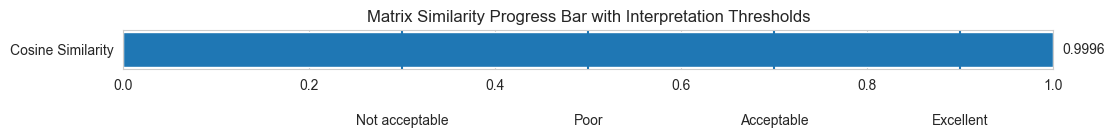

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# === 将矩阵展平成向量 ===
pred_vec = pred_matrix.values.flatten()
actual_vec = actual_matrix.values.flatten()

# === 计算 Pearson 相关系数 ===
pearson_corr = np.corrcoef(pred_vec, actual_vec)[0, 1]

# === 计算 Cosine 相似度 ===
cos_sim = cosine_similarity(pred_vec.reshape(1, -1), actual_vec.reshape(1, -1))[0, 0]

print("🔗 Similarity Metrics Between Predicted and Observed Matrices")
print(f"• Pearson Correlation: {pearson_corr:.4f}")
print(f"• Cosine Similarity:   {cos_sim:.4f}")

# === 可选：输出矩阵差异大小（Frobenius 范数） ===
fro_norm = np.linalg.norm(pred_matrix.values - actual_matrix.values)
print(f"• Frobenius Distance:  {fro_norm:.4f}")

import matplotlib.pyplot as plt

value = cos_sim  # your similarity value

plt.figure(figsize=(12, 0.5))
plt.xlim(0, 1)

# Progress bar
plt.barh(["Cosine Similarity"], [value], height=0.2)

# Add value label
plt.text(value + 0.01, 0, f"{value:.4f}", va='center')

# Threshold lines
thresholds = [0.3, 0.5, 0.7, 0.9]
labels = ["Not acceptable", "Poor", "Acceptable", "Excellent"]

for t, label in zip(thresholds, labels):
    plt.axvline(t, linestyle="--")
    plt.text(t, -0.45, label, ha="center", va="bottom")

plt.title("Matrix Similarity Progress Bar with Interpretation Thresholds")
plt.tight_layout()
plt.show()

### 💡 **Empirical Finding**

High-sensitivity users cancel **far less** when no deposit is required, but cancel **almost universally** when forced to pay a deposit.
In contrast, low-sensitivity users cancel **far more** without a deposit, and the deposit **successfully suppresses cancellations**.

| Group           | Meaning                                 | **Baseline Cancel (No Deposit)** | **Baseline Cancel (With Deposit)** | **Observed Cancel (With Deposit)** | **Observed Cancel (No Deposit)** |
| --------------- | --------------------------------------- | -------------------------------- | ---------------------------------- | ---------------------------------- | -------------------------------- |
| **High-Uplift** | Deposit-sensitive / Already committed   | **0.172**                        | **0.992**                          | **0.999**                          | **0.155**                        |
| **Low-Uplift**  | Deposit-insensitive / Unstable planners | **0.279**                        | **0.041**                          | **0.035**                          | **0.288**                        |


### 🎯 **Business Strategy**

- **Enforce deposits for low-sensitivity users**
  Deposits reduce their cancellation rate from **28.8% → 3.5%**.

- **Waive deposits for high-sensitivity users**
  Avoid forcing commitment that triggers cancellations (**15.5% → 99.9%** when a deposit is required).

- **For high-sensitivity users: suppress post-booking stimuli**
  Do *not* send upgrade offers or alternative recommendations — prevents regret-driven cancellations.


---

### 🔍 **Interpretation**

Deposits do **not** function as a universal deterrent.
Instead, they operate as a **behavioral selection mechanism**:

| Customer Type        | Psychological Pattern           | Effect of Deposit                                    | Recommended Strategy                           |
| -------------------- | ------------------------------- | ---------------------------------------------------- | ---------------------------------------------- |
| **Low-Sensitivity**  | Goal-directed, low regret       | Deposit reinforces commitment                        | **Collect deposit**                            |
| **High-Sensitivity** | Ambivalent, prone to indecision | Deposit *intensifies* anxiety → risk of cancellation | **Waive deposit & avoid post-booking stimuli** |

In other words:

> **Deposits filter customers; they do not discipline them.**
> Therefore, the optimal policy is **behaviorally adaptive**, not uniform.

Uniform policies destroy value.
Uplift-based segmentation **creates value by aligning policy with psychological profiles.**



In [39]:
!jupyter nbconvert --to html uplift_modelling.ipynb

[NbConvertApp] Converting notebook uplift_modelling.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('jetTransient' was unexpected)

Failed validating 'additionalProperties' in display_data:

On instance['cells'][4]['outputs'][0]:
{'data': {'image/png': 'iVBORw0KGgoAAAANSUhEUgAAAhcAAAGHCAYAAAADV3CWAAAAOXRFWHRTb2Z0d2Fy...',
          'text/plain': '<Figure size 600x400 with 1 Axes>'},
 'jetTransient': {'display_id': None},
 'metadata': {},
 'output_type': 'display_data'}
[NbConvertApp] WARNING | Alternative text is missing on 13 image(s).
[NbConvertApp] Writing 978393 bytes to uplift_modelling.html


In [35]:
# %system jupyter nbconvert --to html uplift_modelling.ipynb

In [36]:
# !jupyter nbconvert --to webpdf --WebPDFExporter.margin=none uplift_modelling.ipynb

In [37]:
# !jupyter nbconvert --to html --no-input uplift_modelling.ipynb